In [1]:
import os, sys
from pathlib import Path 
sys.path.append(str(Path().resolve().parent))
from src.dataset.clustering_dataset import ClusteringDataset
import torch

In [1]:
# 例: Notebook / スクリプト側
import sys
from pathlib import Path 
sys.path.append(str(Path().resolve().parent))
from src.dataset.clustering_dataset import ClusteringDataset, UnicodeClassMapper
from torch.utils.data import DataLoader

root_dir = r"C:\Users\kotat\MyPrograms\MyKuzushiji\kuzushiji-recognition\char_sep_datas"

test_docs = [
    "200021637","100249371","100249537","200005598",
    "200014740","200020019","200021712","200021869",
]

# 1) まず train/test を作る（mapper を共有するとクラス次元Cが揃います）
mapper = UnicodeClassMapper()

train_ds = ClusteringDataset(
    root_dir=root_dir,
    canvas_width=2048,
    patch_size=256,
    test_mode=False,
    test_docs=test_docs,
    mapper=mapper,
)

test_ds = ClusteringDataset(
    root_dir=root_dir,
    canvas_width=2048,
    patch_size=256,
    test_mode=True,
    test_docs=test_docs,
    mapper=mapper,  # ★同じmapper
)

print("train:", len(train_ds), "test:", len(test_ds))
print("num_classes(C):", mapper.num_classes)

# 2) 1サンプル取り出し
sample = train_ds[6]
img = sample["image"]                 # (3,H,W) float32 0..1
final_mask = sample["final_text_mask"]# (H,W) 0/1
aff_mask = sample["affinity_mask"]    # (H,W) 0/1
label_map = sample["label_map"]       # (H,W,C) one-hot
meta = sample["meta"]

print(img.shape, final_mask.shape, aff_mask.shape, label_map.shape, meta)

# 3) DataLoader で回す
loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
batch = next(iter(loader))
print(batch["image"].shape)          # (B,3,H,W)
print(batch["label_map"].shape)      # (B,H ,W,C)

train: 5204 test: 947
num_classes(C): 159
torch.Size([3, 3328, 2048]) torch.Size([3328, 2048]) torch.Size([3328, 2048]) torch.Size([3328, 2048, 159]) {'doc_id': '100241706', 'image_id': '100241706_00004_2', 'image_path': 'C:\\Users\\kotat\\MyPrograms\\MyKuzushiji\\kuzushiji-recognition\\char_sep_datas\\100241706\\images\\100241706_00004_2.jpg', 'num_classes': 159}
torch.Size([1, 3, 3328, 2048])
torch.Size([1, 3328, 2048, 159])


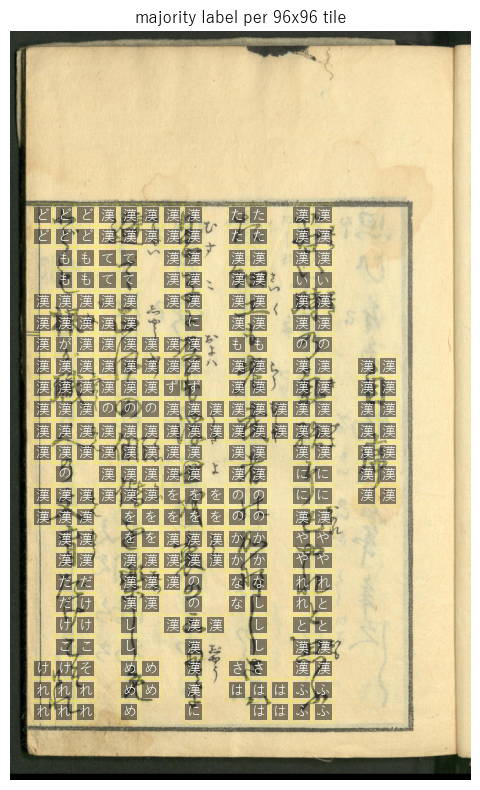

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

# どれか1つ通るものを使ってください（環境により入っているフォントが違います）
mpl.rcParams["font.family"] = "Yu Gothic"   # 例: Windows標準のことが多い
# mpl.rcParams["font.family"] = "Meiryo"
# mpl.rcParams["font.family"] = "MS Gothic"

# ついでによくある「マイナス記号が□」問題を回避
mpl.rcParams["axes.unicode_minus"] = False

def _build_class_name_fn(mapper):
    # class_id -> 表示文字
    inv_kana = {v: k for k, v in mapper._kana_to_id.items()}  # class_id -> codepoint

    def name(cid: int) -> str:
        if cid < 0:
            return ""
        if cid == 0:
            return "漢"  # 漢字(others)
        cp = inv_kana.get(cid, None)
        if cp is None:
            return f"c{cid}"
        return chr(cp)  # かなは実文字
    return name

def visualize_majority_label_grid(
    sample: dict,
    tile: int = 128,
    min_labeled_ratio: float = 0.02,
    draw_grid: bool = True,
):
    """
    sample: ClusteringDataset の 1サンプル dict
      sample["image"]    : (3,H,W)
      sample["label_map"]: (H,W,C)
      sample["meta"]     : mapperは sample ではなく dataset.mapper から取る想定でもOK
    tile: タイルの一辺(px)
    min_labeled_ratio: タイル内の「ラベル付き画素」割合がこれ未満なら表示しない
    """
    img_t = sample["image"]
    label_map_t = sample["label_map"]
    mapper = sample.get("mapper", None)  # 任意
    if mapper is None:
        # Notebookでは train_ds.mapper を使う想定
        raise ValueError('sample["mapper"] が無いので、sampleに mapper を入れるか train_ds.mapper を渡す形にしてください')

    img = img_t.permute(1, 2, 0).detach().cpu().numpy()  # (H,W,3)
    label_map = label_map_t.detach().cpu()               # (H,W,C)
    H, W, C = label_map.shape

    class_name = _build_class_name_fn(mapper)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    ax.set_title(f"majority label per {tile}x{tile} tile")
    ax.axis("off")

    # タイルごとに集計
    for y0 in range(0, H, tile):
        y1 = min(y0 + tile, H)
        for x0 in range(0, W, tile):
            x1 = min(x0 + tile, W)

            block = label_map[y0:y1, x0:x1, :]  # (h,w,C)
            # 背景(全0画素)を除外
            labeled = (block.sum(dim=-1) > 0)    # (h,w)
            labeled_count = int(labeled.sum().item())
            area = (y1 - y0) * (x1 - x0)

            if labeled_count == 0 or labeled_count / area < min_labeled_ratio:
                continue

            # クラス別の「ラベル付き画素での合計」を出す
            # (h,w,C) -> (C,)
            counts = block[labeled].sum(dim=0)  # float合計（one-hotなので画素数に等しい）
            cid = int(torch.argmax(counts).item())

            text = class_name(cid)
            if not text:
                continue

            cx = (x0 + x1) / 2
            cy = (y0 + y1) / 2

            ax.text(
                cx, cy, text,
                ha="center", va="center",
                fontsize=10,
                color="white",
                bbox=dict(facecolor="black", alpha=0.45, pad=1, edgecolor="none"),
            )

            if draw_grid:
                ax.add_patch(
                    plt.Rectangle(
                        (x0, y0), x1 - x0, y1 - y0,
                        fill=False, edgecolor="yellow", linewidth=0.3, alpha=0.6
                    )
                )

    plt.tight_layout()
    plt.show()

# --- 使い方例 ---
# sample に mapper を入れてから呼ぶ（簡単）
sample = train_ds[6]
sample["mapper"] = train_ds.mapper
visualize_majority_label_grid(sample, tile=96, min_labeled_ratio=0.02, draw_grid=True)